# Interpreting Image Classification of Keras InceptionV3

This notebook examines the predictions of an image classfifier (CNN InceptionV3) using two interpretation methods:

> * LimeImageExplainer (LIME)
> * Class Activation Maps (CAM)

* First, LIME and CAM will be applied on a single prediction to make their concepts easier to understand. 
* In the following section, both methods are systematically applied to a group of predictions and compared using their masks
* The Images used in this notebook can be downloaded from ImageNet: [*Download from here*](http://image-net.org/imagenet_data/urls/imagenet_fall11_urls.tgz)

In [1]:
#process not on GPU
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
# Keras
import keras
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array
# Tools requiered for visualizing and processing
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [3]:
model_InceptionV3 = InceptionV3(weights = 'imagenet')

W0705 15:01:05.056303 140050468828800 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0705 15:01:05.070697 140050468828800 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0705 15:01:05.073452 140050468828800 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0705 15:01:05.090164 140050468828800 deprecation_wrapper.py:119] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0705 15:01:05.090677 140050468828800 deprecation_wrappe

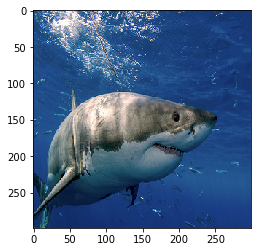

In [4]:
# Load image and scale to 299x299
image_raw = load_img("/home/common_files/datasets/imagenet/bounding_boxes/n01484850/n01484850_10798.jpg",target_size = (299,299))
plt.imshow(image_raw)

In [5]:
# Preprocess image in an array to make it compatible with the Keras model and reshape it.
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [6]:
# Predict label of image
prediction = model_InceptionV3.predict(image)
pd.DataFrame(decode_predictions(prediction, top=3)[0],columns=['col1','class','probability']).iloc[:,1:]

class  probability
0  great_white_shark     0.938497
1        tiger_shark     0.001046
2         grey_whale     0.000489

In [7]:
import lime
from lime.lime_image import LimeImageExplainer
# Requiered segmentation package for creating superpixel of image
from skimage.segmentation import mark_boundaries, quickshift
import numpy as np

In [8]:
explainer = LimeImageExplainer()

Number of superpixel:  65


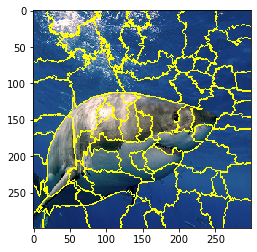

In [9]:
# This part is optional and is listed to make clear the idea behind LimeImageExplainer. This means Lime does this automatically in the back.
# Lime is creating superpixels using the segmentation algorithm quickshift like below, and predicts the image user-defined-times by turning superpixel on and off

segments = quickshift(image_raw, kernel_size=4, max_dist=200, ratio=0.2,random_seed=42)
superpixel = mark_boundaries(image_raw, segments)
plt.imshow(superpixel)
print('Number of superpixel: ',len(np.unique(segments)))

In [10]:
# pass image as (299,299,3)-Array 299x299Pixel in RGB
# top_labels = 3 -> create explanation for top three labels predicted by the model for image
# num_samples = 500 -> create 500 similiar pictures by turning superpixel on and off 
# random_seed = 42 -> for reproducability of segmenation (superpixel)

explanation = explainer.explain_instance(image[0], model_InceptionV3.predict, top_labels=3, num_samples=500, random_seed=42)

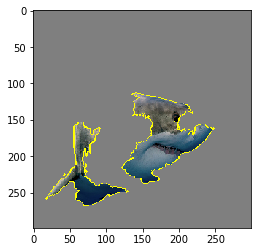

In [11]:
# Show top five (by default) Superpixel with positive weights supported decision making

temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True,  hide_rest=True)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)

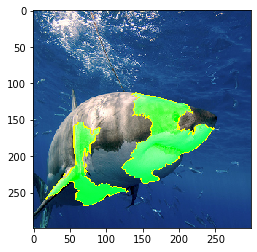

In [12]:
# explanation.top_labels[0] -> index of highest probable predicted class
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False,   hide_rest=False)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)


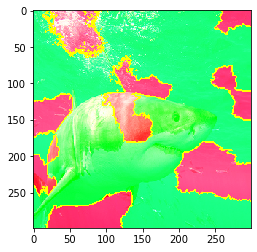

In [13]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=len(np.unique(segments)),hide_rest=False)
top_superpixels = mark_boundaries(temp /2 + .5,mask)
plt.imshow(top_superpixels)

In [14]:
results_images_df = pd.read_hdf('results-inceptionv3-1.h5',key='pictures')
results_images_df.sort_values(['confidence_difference'], ascending=False).head(5)

label_id label_name1       label_name2  prediction_id prediction_name1  \
0       207   n02099601  golden_retriever            971        n09229709   
0       207   n02099601  golden_retriever            475        n02965783   
0       263   n02113023          Pembroke            805        n04254680   
0       541   n03249569              drum            822        n04311174   
0       880   n04509417          unicycle            475        n02965783   

  prediction_name2                      file_name  confidence_in_prediction  \
0           bubble   n02099601/n02099601_4933.jpg                       1.0   
0       car_mirror   n02099601/n02099601_2077.jpg                       1.0   
0      soccer_ball   n02113023/n02113023_8857.jpg                       1.0   
0       steel_drum  n03249569/n03249569_14988.jpg                       1.0   
0       car_mirror   n04509417/n04509417_1366.jpg                       1.0   

   prediction_in_top_5  confidence_in_label  confidence_difference  
0                False         2.533398e-08                    1.0  
0                False         4.801222e-11                    1.0  
0                False         1.617717e-08                    1.0  
0                False         2.191712e-08                    1.0  
0                False         5.660312e-10                    1.0

In [15]:
%%html
<style>
table {float:left}
</style>

### Columns of dataset explained

| Column | Explanation |
| --- | --- |
| label_id | index of actual label |
| label_name1 | encoded actual label |
| label_name2  | decoded actual label |
| prediction_id | index of predicted label |
| prediction_name1 | encoded predicted label |
| prediction_name2 | decoded predicted label |
| file_name | directory of image |
| confidence_in_prediction | probability for predicted label by model |
| prediction_in_top_5 | True, if actual label is in top five of predicted classes, otherwise False |
|confidence_in_label   | probability for actual label predicted by model|
confidence_difference   |confidence_in_prediction - confidence_in_label|

In [16]:
# To load images
def get_image(image_dir):
    image = load_img("/home/common_files/datasets/imagenet/pictures/"+image_dir,target_size = (299,299))
    return image    

In [17]:
# Preprocess image in an array to make it compatible with the Keras model and reshape it. 
def preprocess_image(image_raw):
    image = img_to_array(image_raw)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    return image[0]

In [18]:
# Create explanation of Image
def explanation_for_instance(image,model):
    explanation = explainer.explain_instance(image,model.predict,top_labels = 1,num_samples=500,random_seed=42)
    return explanation

In [19]:
# Mask explanation and return top ten superpixel for most probable prediction of model and hide rest of image
def get_explained_image(explanation, positive_only, hide_rest):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only = positive_only, num_features=10, hide_rest=hide_rest)
    bounderies = mark_boundaries(temp /2 + .5,mask)
    return bounderies

### Create explanation in loop

* We want to create explanations for only images where confidence_difference is higher than 0.98 since we have more than 100 000 false predictions 
* And it takes to much time generate an explanation for an image

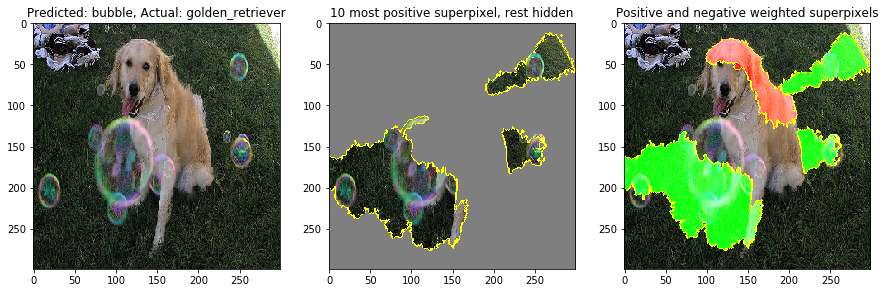

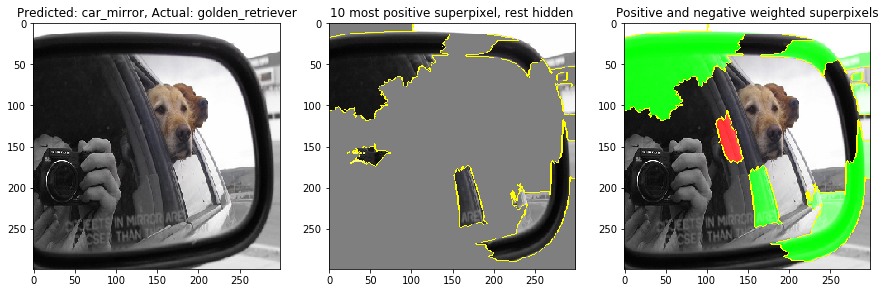

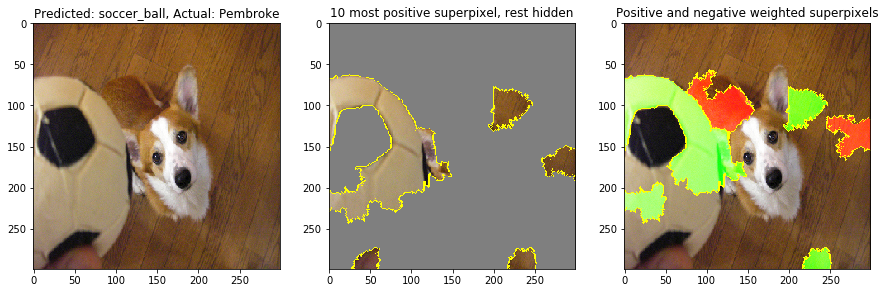

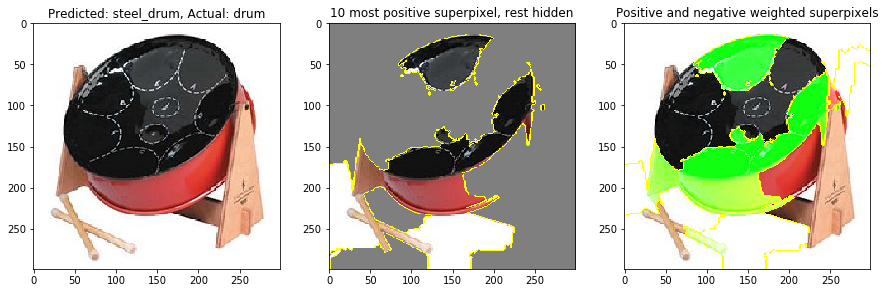

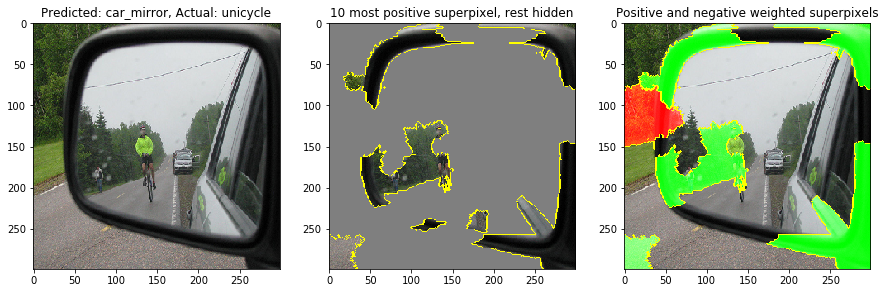

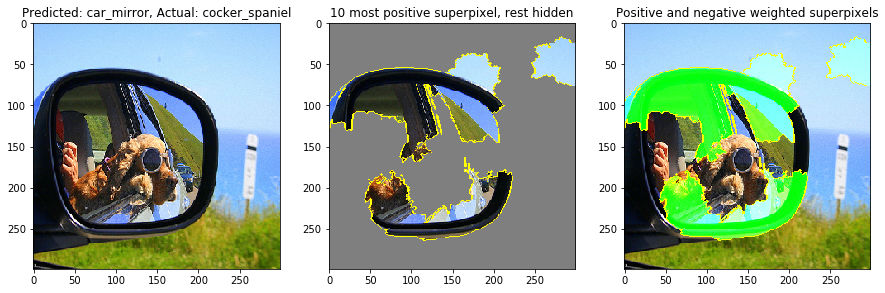

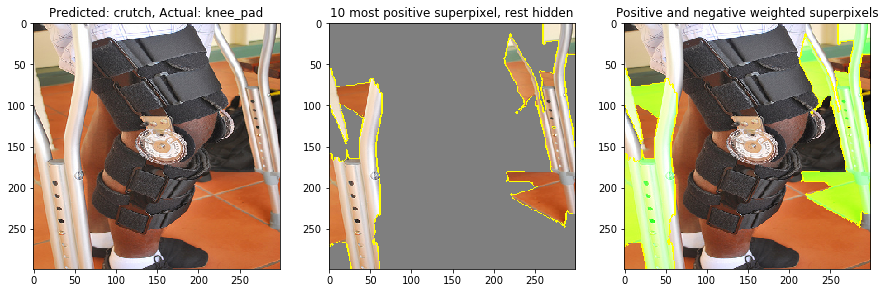

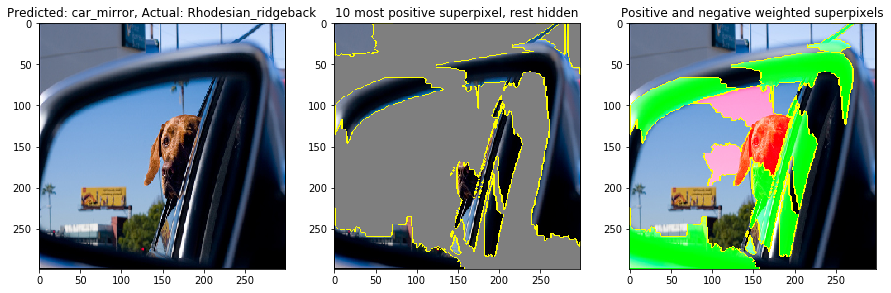

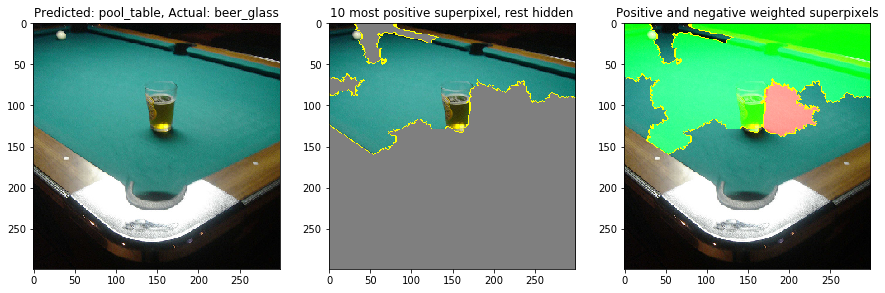

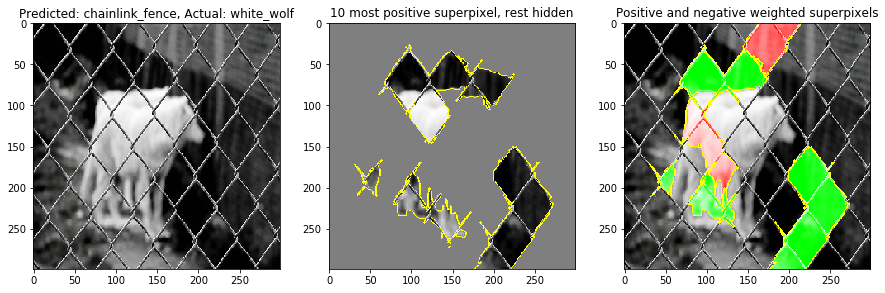

In [21]:
# Order dataframe by confidence_difference descending to make iteration more efficent
results_images_df = results_images_df.sort_values(['confidence_difference'], ascending=False)

# Create explanation in loop

for i in range(len(results_images_df)):
    
    file_name = results_images_df.iloc[i]['file_name']
    image_raw = get_image(file_name)
    image = preprocess_image(image_raw)
    # Create explanation for predicted label
    explanation = explanation_for_instance(image, model_InceptionV3)
    # get explained image with 10 positive weighted superpixel and hide rest
    explained_image_positive_and_hidden = get_explained_image(explanation, positive_only = True, hide_rest= True)
    # get explained image with 10 positive or negative weigthed superpixel, hide_rest = False
    explained_image_pos_neg = get_explained_image(explanation, positive_only = False, hide_rest= False)
    
    #plt.savefig('../Output_Images/Predicted_ {}, Actual_ {}'.format(results_images_df.iloc[i]['prediction_name2'],results_images_df.iloc[i]['label_name2']))
    
    #plot only first 10
    if i < 10:
        
        fig, ax = plt.subplots(1,3, figsize = (15,15))
        ax[0].imshow(image_raw)
        ax[0].set_title('Predicted: {}, Actual: {}'.format(results_images_df.iloc[i]['prediction_name2'],results_images_df.iloc[i]['label_name2']), fontsize =12)
        ax[1].imshow(explained_image_positive_and_hidden)
        ax[1].set_title('10 most positive superpixel, rest hidden')
        ax[2].imshow(explained_image_pos_neg)
        ax[2].set_title('Positive and negative weighted superpixels')
        plt.show()
    
    if results_images_df.iloc[i]['confidence_difference'] < 0.98:
        break
    
    if i >=10:
        break

## Lime vs Class Activation Maps

* In this section Class Activation Maps are generated and compared with the results of the LimeImageExplainer.

* Class Activation Maps are simple to implement and can help to get the discriminative image regions used by a CNN to identify a specific class in the image. 

* Class Activation Maps are often called as Attention Maps

### Get Class Activation Map for a single prediction

In [20]:
# import keras-vis
import vis
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay, visualize_cam,visualize_cam_with_losses
from keras import activations
import os
import xml.etree.ElementTree as ET
import matplotlib.patches as patches
import h5py

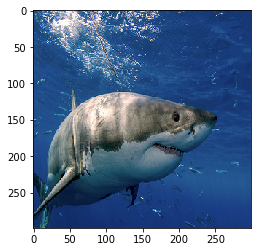

In [21]:
image_raw = load_img("/home/common_files/datasets/imagenet/bounding_boxes/n01484850/n01484850_10798.jpg",target_size = (299,299))
plt.imshow(image_raw)

# n01910747_13855.jpg
# n01484850/n01484850_10798.jpg
# n01560419/n01560419_1316.jpg
# n01910747/n01910747_15064.jpg

In [22]:
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

In [23]:
prediction = model_InceptionV3.predict(image)
print(pd.DataFrame(decode_predictions(prediction, top=3)[0],columns=['col1','class','probability']).iloc[:,1:])
# get corrosponding imagenet index for prediction
argmax = np.argmax(prediction[0])
print('\nImageNet Index for prediction: ',argmax)

               class  probability
0  great_white_shark     0.938497
1        tiger_shark     0.001046
2         grey_whale     0.000489

ImageNet Index for prediction:  2


In [24]:
# get last layer
prediction_layer = model_InceptionV3.get_layer('predictions')
print(prediction_layer)

In [25]:
# get index of last layer
prediction_layer_idx = utils.find_layer_idx(model_InceptionV3, 'predictions')
print(prediction_layer_idx)

312


(299, 299, 3)

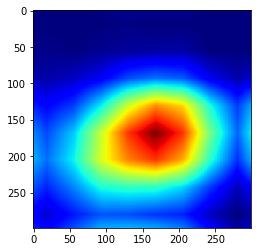

In [26]:
cam = visualize_cam(model=model_InceptionV3, layer_idx=prediction_layer_idx, filter_indices=argmax, seed_input=image)#, backprop_modifier='relu', grad_modifier='absolute')
plt.imshow(cam)
cam.shape

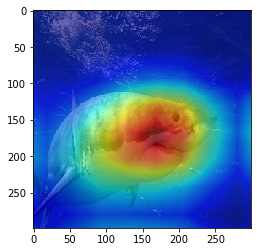

In [27]:
plt.imshow(overlay(np.array(image_raw),cam, alpha=0.4))

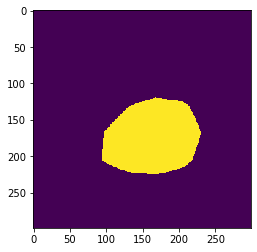

In [28]:
# Get the red area of the attention_map (most positive area for classification of cnn)
# where blue channel is under 100
cam_mask = np.zeros((299,299))
mask = (cam[:,:,2] < 30)
cam_mask[mask] = 1
plt.imshow(cam_mask)

Explanation score:  0.48172403807442987


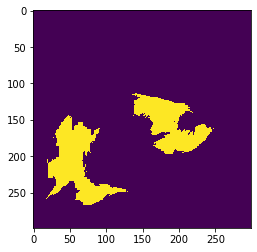

In [29]:
# get lime mask for top 5 superpixel of actual label
explanation = explainer.explain_instance(image[0], model_InceptionV3.predict,num_samples = 500, labels = (argmax,), top_labels = None, random_seed=42)
temp, lime_mask = explanation.get_image_and_mask(argmax, positive_only = True,  hide_rest = True)
boundaries = mark_boundaries(temp/2+.5, lime_mask)
plt.imshow(lime_mask)
print('Explanation score: ', explanation.score )

## Compare Lime with bounding boxes

[{'xmin': 1, 'ymin': 118, 'xmax': 422, 'ymax': 332, 'xminScalled': 0, 'yminScalled': 105, 'xmaxScalled': 252, 'ymaxScalled': 298, 'xdiff': 421, 'ydiff': 214, 'xdiffScalled': 252, 'ydiffScalled': 193}]


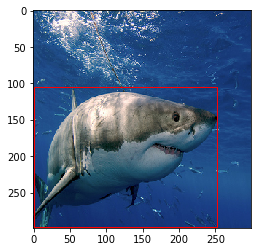

In [32]:
# get image with bounding box

path_to_xml = '/home/common_files/datasets/imagenet/bounding_boxes/n01484850/n01484850_10798.xml'

bounding_boxes = loadBoundingBoxes(path_to_xml,np.array(image_raw).shape[0],np.array(image_raw).shape[1])

# Create rectangle patch
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.imshow(np.array(image_raw))

for bounding_box in bounding_boxes:
    rect = patches.Rectangle((bounding_box['xminScalled'],bounding_box['yminScalled']),bounding_box['xdiffScalled'],bounding_box['ydiffScalled'],linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)

plt.show()

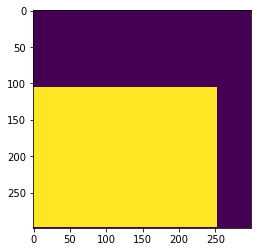

In [33]:
# get mask for bounding box

bounding_box_mask = np.zeros((299,299))
for bounding_box in bounding_boxes:
        bounding_box_mask[bounding_box['yminScalled']:bounding_box['ymaxScalled'],bounding_box['xminScalled']:bounding_box['xmaxScalled']] = 1
plt.imshow(bounding_box_mask)

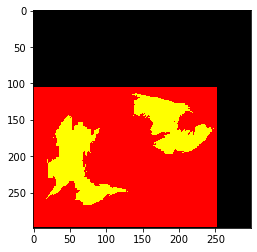

In [34]:
# compare masks:  goal is to get intersection of both masks and see the percentage of lime in bounding box

both_masks = np.zeros((299,299,3))
both_masks[:,:,0]  = bounding_box_mask
both_masks[:,:,1]  = lime_mask

plt.imshow(both_masks)

In [35]:
pixel_both_masks = ((lime_mask+bounding_box_mask) == 2).sum()
pixel_lime_mask = (lime_mask == 1).sum() - pixel_both_masks
lime_in_bounding_box = pixel_both_masks / (pixel_lime_mask + pixel_both_masks)
print('Lime explanation in bounding box in %: ',lime_in_bounding_box*100)

Lime explanation in bounding box in %:  100.0


## Compare Class Activation Map with bounding boxes

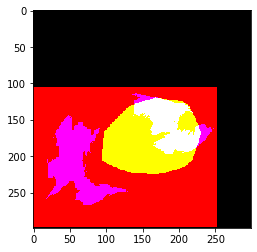

In [157]:
both_masks = np.zeros((299,299,3))
both_masks[:,:,0] = bounding_box_mask
both_masks[:,:,1] = cam_mask
both_masks[:,:,2] = lime_mask

plt.imshow(both_masks)

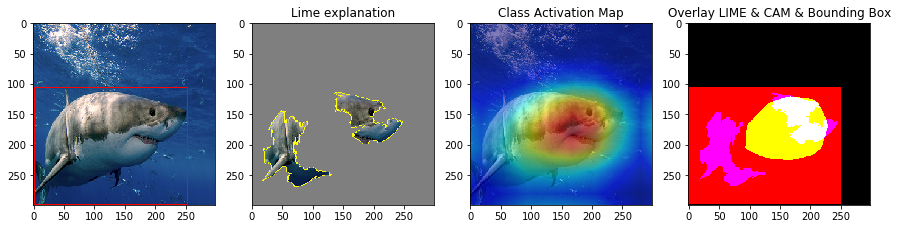

In [163]:
fig, ax = plt.subplots(1,4, figsize = (15,15))
ax[0].imshow(np.array(image_raw))

for bounding_box in bounding_boxes:
    rect = patches.Rectangle((bounding_box['xminScalled'],bounding_box['yminScalled']),bounding_box['xdiffScalled'],bounding_box['ydiffScalled'],linewidth=1,edgecolor='r',facecolor='none')
    ax[0].add_patch(rect)

ax[1].imshow(boundaries)
ax[1].set_title('Lime explanation')
ax[2].imshow(overlay(np.array(image_raw),cam, alpha=0.5))
ax[2].set_title('Class Activation Map')
ax[3].imshow(both_masks)
ax[3].set_title('Overlay LIME & CAM & Bounding Box')
plt.show()

In [37]:
both_masks = np.zeros((299,299,3))
pixel_both_masks = ((cam_mask+bounding_box_mask) == 2).sum()
pixel_cam_mask = (cam_mask == 1).sum() - pixel_both_masks
cam_in_bounding_box = pixel_both_masks / (pixel_cam_mask + pixel_both_masks)
print('Class Activation Map in bounding box in %: ',cam_in_bounding_box * 100)

Class Activation Map in bounding box in %:  100.0


## Approach to detect bias in training data systematically using Lime and Class Activation Maps

* We predicted 11 100 images using the InceptionV3 CNN and saved the results in a dataframe
* Dataframe contains masks of explanations, bounding boxes and predicted classes
* In total 222 classes, each 50 Samples

In [38]:
base_path = '/home/common_files/datasets/imagenet/bounding_boxes'
results_file = '/home/viscif/akif/mask_results.h5'

In [39]:
# load resultsfile

class_names = []
if os.path.isfile(results_file):
    with h5py.File(results_file, 'r') as hf:
        keys = hf.keys()
        #print(keys)
        for x in keys:
            class_names.append(x)

In [41]:
xxx = pd.read_hdf(results_file, key = 'n01443537' )
xxx.head(5)

index                                           LimeMask  \
0      0  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
1      1  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
2      2  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
3      3  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   
4      4  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...   

                                       boundingBoxes             filename  \
0  [{'xmin': 0, 'ymin': 81, 'xmax': 388, 'ymax': ...  n01443537_15077.jpg   
1  [{'xmin': 0, 'ymin': 32, 'xmax': 470, 'ymax': ...   n01443537_3770.jpg   
2  [{'xmin': 33, 'ymin': 7, 'xmax': 483, 'ymax': ...  n01443537_14753.jpg   
3  [{'xmin': 4, 'ymin': 3, 'xmax': 370, 'ymax': 3...  n01443537_15164.jpg   
4  [{'xmin': 82, 'ymin': 42, 'xmax': 459, 'ymax':...  n01443537_17158.jpg   

  imageClass  imageClassID                                         prediction  \
0  n01443537             1  [0.4695126, 0.42171732, 3.176042e-05, 7.95988e...   
1  n01443537             1  [5.8828384e-05, 0.9815384, 5.201997e-06, 2.323...   
2  n01443537             1  [7.35271e-05, 0.98377395, 1.1630094e-05, 1.536...   
3  n01443537             1  [5.3010226e-06, 0.9981963, 3.8723888e-07, 1.02...   
4  n01443537             1  [9.254664e-06, 0.9950423, 1.3036793e-06, 3.471...   

                                        attentionMap  lime_score  \
0  [[[0, 0, 127], [0, 0, 127], [0, 0, 127], [0, 0...    0.754628   
1  [[[0, 76, 255], [0, 72, 255], [0, 72, 255], [0...    0.866595   
2  [[[0, 0, 127], [0, 0, 127], [0, 0, 127], [0, 0...    0.695441   
3  [[[0, 0, 154], [0, 0, 154], [0, 0, 150], [0, 0...    0.817954   
4  [[[0, 0, 127], [0, 0, 127], [0, 0, 127], [0, 0...    0.685793   

           lime_local_pred           lime_intercept  \
0   {1: 1.267693792724557}   {1: 1.267693792724557}   
1  {1: 0.3209959091414734}  {1: 0.3209959091414734}   
2  {1: 0.8691169971423763}  {1: 0.8691169971423763}   
3  {1: 0.8782302691236076}  {1: 0.8782302691236076}   
4  {1: 0.5669422930978077}  {1: 0.5669422930978077}   

                                      lime_local_exp  
0  {1: [(17, -0.06994722828292095), (49, -0.06448...  
1  {1: [(38, 0.24313867491509353), (34, 0.1759696...  
2  {1: [(29, 0.03367669656723959), (39, 0.0291292...  
3  {1: [(15, 0.06525776812932092), (44, -0.035961...  
4  {1: [(44, 0.13990932507497805), (33, 0.1160037...

In [42]:
def analyze_row(dataset_row):
    
    file_name = dataset_row['filename']
    image_class =  dataset_row['imageClass']
    image_class_index = dataset_row['imageClassID']
    
    cam_map = dataset_row['attentionMap']
    cam_mask = get_cam_mask(cam_map)
    lime_mask = dataset_row['LimeMask']
    bounding_box = dataset_row['boundingBoxes']
    bounding_box_mask = get_bounding_box_mask(bounding_box)
    
    area_bounding_box = ((bounding_box_mask) == 1).sum()
    area_lime = ((lime_mask) == 1).sum()
    area_cam = ((cam_mask) == 1).sum()
    
    area_intersection_boundingbox_lime = ((bounding_box_mask + lime_mask) == 2).sum()
    area_intersection_boundingbox_cam = ((bounding_box_mask + cam_mask) == 2).sum()
    
    overlap_lime_bounding_box = max(area_intersection_boundingbox_lime / area_lime, area_intersection_boundingbox_lime / area_bounding_box)
    overlap_cam_bounding_box = max(area_intersection_boundingbox_cam / area_cam, area_intersection_boundingbox_cam / area_bounding_box)
    
    lime_explanation_score = dataset_row['lime_score']
    
    
    data = {
        
        'file_name' : [file_name],
        'image_class' : [image_class],
        'image_class_index' : [image_class_index],        
        'area_lime' : [area_lime],
        'area_cam' : [area_cam],
        'area_intersection_boundingbox_cam' : [area_intersection_boundingbox_cam],
        'area_intersection_boundingbox_lime' : [area_intersection_boundingbox_lime],
        'overlap_lime_bounding_box' : [overlap_lime_bounding_box],
        'overlap_cam_bounding_box' : [overlap_cam_bounding_box],
        'lime_explanation_score' : [lime_explanation_score]
    
    }
    
    return data

In [43]:
def get_bounding_box_mask(bounding_box):
    bounding_box_mask = np.zeros((299,299))
    for bounding_box in bounding_boxes:
        bounding_box_mask[bounding_box['yminScalled']:bounding_box['ymaxScalled'],bounding_box['xminScalled']:bounding_box['xmaxScalled']] = 1
    return bounding_box_mask

In [44]:
def get_cam_mask(cam):
    cam_mask = np.zeros((299,299))
    mask = (cam[:,:,2] < 30) # ändern
    cam_mask[mask] = 1
    return cam_mask

In [71]:
# Analyse row-wise 
all_results_dict = {}
all_results_df = pd.DataFrame()
for class_name in class_names:
    
    class_results = pd.DataFrame()
    dataset = pd.read_hdf(results_file, key = class_name)
    
    for i in range(len(dataset)):
        row = dataset.iloc[i]
        #print(row)
        data = analyze_row(row)
        class_results = class_results.append(pd.DataFrame(data), ignore_index = False)
        all_results_df = all_results_df.append(pd.DataFrame(data), ignore_index = False)
        #print(class_results)
        
    all_results_dict.update({class_name : class_results})


/usr/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in long_scalars


In [142]:
# get statistics for each class

def get_statistics_for_classes(class_name):
    #print('class_name: ' ,class_name)
    min_overlap_lime_bb_percentage = all_results_dict[class_name]['overlap_lime_bounding_box'].min()
    mean_overlap_lime_bb_percentage = all_results_dict[class_name]['overlap_lime_bounding_box'].mean()
    max_overlap_lime_bb_percentage = all_results_dict[class_name]['overlap_lime_bounding_box'].max()
    std_overlap_lime_bb_percentage = all_results_dict[class_name]['overlap_lime_bounding_box'].std()
    
    min_lime_explanation_score = all_results_dict[class_name]['lime_explanation_score'].min()
    mean_lime_explanation_score = all_results_dict[class_name]['lime_explanation_score'].mean()
    max_lime_explanation_score = all_results_dict[class_name]['lime_explanation_score'].max()
    std_lime_explanation_score = all_results_dict[class_name]['lime_explanation_score'].std()
    corr_lime_exp_score_overlap = all_results_dict[class_name]['lime_explanation_score'].corr(all_results_dict[class_name]['overlap_lime_bounding_box'])
    
    min_overlap_cam_bb_percentage = all_results_dict[class_name]['overlap_cam_bounding_box'].min()
    mean_overlap_cam_bb_percentage = all_results_dict[class_name]['overlap_cam_bounding_box'].mean()
    max_overlap_cam_bb_percentage = all_results_dict[class_name]['overlap_cam_bounding_box'].max()
    std_overlap_cam_bb_percentage = all_results_dict[class_name]['overlap_cam_bounding_box'].std()
    
    data = {
        'class_name' : [class_name],
        'min_overlap_lime_bb_percentage' : [min_overlap_lime_bb_percentage], 
        'mean_overlap_lime_bb_percentage' : [mean_overlap_lime_bb_percentage],
        'max_overlap_lime_bb_percentage' : [max_overlap_lime_bb_percentage], 
        'std_overlap_lime_bb_percentage' : [std_overlap_lime_bb_percentage],
    
        'min_lime_explanation_score' : [min_lime_explanation_score],
        'mean_lime_explanation_score' : [mean_lime_explanation_score],
        'max_lime_explanation_score' : [max_lime_explanation_score], 
        'std_lime_explanation_score' : [std_lime_explanation_score], 
        'corr_lime_exp_score_overlap' : [corr_lime_exp_score_overlap],
        
        'min_overlap_cam_bb_percentage' : [min_overlap_cam_bb_percentage], 
        'mean_overlap_cam_bb_percentage' : [mean_overlap_cam_bb_percentage],
        'max_overlap_cam_bb_percentage' : [max_overlap_cam_bb_percentage], 
        'std_overlap_cam_bb_percentage' : [std_overlap_cam_bb_percentage ]
        
        
    }
    #print(data)
    return data


In [143]:
all_results_dict['n01443537']['lime_explanation_score'].corr(all_results_dict['n01443537']['overlap_lime_bounding_box'])

0.19631939453799205

In [153]:
statistics_data = pd.DataFrame()

for class_name in class_names:
    statistics = get_statistics_for_classes(class_name)
    statistics_data = statistics_data.append(pd.DataFrame(statistics), ignore_index = True)
    

In [164]:
statistics_data.head(5)

class_name  min_overlap_lime_bb_percentage  mean_overlap_lime_bb_percentage  \
0  n01443537                        0.130980                         0.644487   
1  n01514668                        0.380266                         0.700884   
2  n01530575                        0.251493                         0.759079   
3  n01580077                        0.065105                         0.647101   
4  n01608432                        0.318907                         0.681915   

   max_overlap_lime_bb_percentage  std_overlap_lime_bb_percentage  \
0                        0.951644                        0.220155   
1                        1.000000                        0.172310   
2                        1.000000                        0.202547   
3                        1.000000                        0.225542   
4                        0.995015                        0.162760   

   min_lime_explanation_score  mean_lime_explanation_score  \
0                    0.505949                     0.804652   
1                    0.555522                     0.801230   
2                    0.708780                     0.880305   
3                    0.678395                     0.853971   
4                    0.719685                     0.885994   

   max_lime_explanation_score  std_lime_explanation_score  \
0                    0.949273                    0.105332   
1                    0.951129                    0.104371   
2                    0.975756                    0.057009   
3                    0.989157                    0.080620   
4                    0.964111                    0.053451   

   corr_lime_exp_score_overlap  min_overlap_cam_bb_percentage  \
0                     0.196319                       0.000000   
1                    -0.147696                       0.000000   
2                     0.312330                       0.005501   
3                     0.136120                       0.014437   
4                     0.168782                       0.272206   

   mean_overlap_cam_bb_percentage  max_overlap_cam_bb_percentage  \
0                        0.836811                            1.0   
1                        0.787199                            1.0   
2                        0.869752                            1.0   
3                        0.743248                            1.0   
4                        0.768793                            1.0   

   std_overlap_cam_bb_percentage  
0                       0.233009  
1                       0.269992  
2                       0.224794  
3                       0.239888  
4                       0.210275

In [81]:
all_results_df.head(10)

file_name image_class  image_class_index  area_lime  area_cam  \
0  n01443537_15077.jpg   n01443537                  1       4764      5453   
0   n01443537_3770.jpg   n01443537                  1       9167     13462   
0  n01443537_14753.jpg   n01443537                  1      10706     18342   
0  n01443537_15164.jpg   n01443537                  1       7263     14650   
0  n01443537_17158.jpg   n01443537                  1      10899      9327   
0  n01443537_16234.jpg   n01443537                  1      10346     22012   
0  n01443537_11715.jpg   n01443537                  1      13205     14371   
0  n01443537_14020.jpg   n01443537                  1       8532     11400   
0   n01443537_4678.jpg   n01443537                  1      10553     11715   
0  n01443537_19364.jpg   n01443537                  1       6373       635   

   area_intersection_boundingbox_cam  area_intersection_boundingbox_lime  \
0                               5453                                1528   
0                              12404                                8407   
0                              12409                                6997   
0                               8973                                1370   
0                               9327                                9233   
0                              16752                                6769   
0                              14371                                6814   
0                               6558                                6079   
0                               9244                                5713   
0                                635                                2023   

   overlap_lime_bounding_box  overlap_cam_bounding_box  lime_explanation_score  
0                   0.320739                  1.000000                0.754628  
0                   0.917094                  0.921408                0.866595  
0                   0.653559                  0.676535                0.695441  
0                   0.188627                  0.612491                0.817954  
0                   0.847142                  1.000000                0.685793  
0                   0.654263                  0.761039                0.876673  
0                   0.516017                  1.000000                0.859358  
0                   0.712494                  0.575263                0.829236  
0                   0.541363                  0.789074                0.856640  
0                   0.317433                  1.000000                0.756393

In [74]:
all_results_df.describe()

image_class_index     area_lime      area_cam  \
count       11100.000000  11100.000000  11100.000000   
mean          483.648649  10124.092342  14058.827658   
std           283.801093   3298.999635   7512.424382   
min             1.000000   2400.000000      0.000000   
25%           237.000000   7767.500000   9194.750000   
50%           486.500000   9694.500000  12333.500000   
75%           733.000000  12028.000000  17111.250000   
max           999.000000  28845.000000  67123.000000   

       area_intersection_boundingbox_cam  area_intersection_boundingbox_lime  \
count                       11100.000000                        11100.000000   
mean                         9884.089099                         6761.003514   
std                          6299.555399                         3132.562048   
min                             0.000000                            0.000000   
25%                          5789.500000                         4495.000000   
50%                          9178.000000                         6486.000000   
75%                         13023.500000                         8711.250000   
max                         48635.000000                        23788.000000   

       overlap_lime_bounding_box  overlap_cam_bounding_box  \
count               11100.000000              11093.000000   
mean                    0.667825                  0.702963   
std                     0.221323                  0.300652   
min                     0.000000                  0.000000   
25%                     0.518367                  0.521302   
50%                     0.693193                  0.795536   
75%                     0.844566                  0.980935   
max                     1.000000                  1.000000   

       lime_explanation_score  
count            11100.000000  
mean                 0.832392  
std                  0.083350  
min                  0.173414  
25%                  0.790363  
50%                  0.847984  
75%                  0.890675  
max                  0.992284

In [73]:
all_results_df.corr()

image_class_index  area_lime  area_cam  \
image_class_index                            1.000000   0.025868  0.153080   
area_lime                                    0.025868   1.000000  0.082476   
area_cam                                     0.153080   0.082476  1.000000   
area_intersection_boundingbox_cam            0.083944   0.072366  0.774075   
area_intersection_boundingbox_lime          -0.008009   0.685476  0.017589   
overlap_lime_bounding_box                   -0.042630  -0.000164 -0.052335   
overlap_cam_bounding_box                    -0.080384   0.009114  0.004925   
lime_explanation_score                      -0.099630  -0.058426 -0.020085   

                                    area_intersection_boundingbox_cam  \
image_class_index                                            0.083944   
area_lime                                                    0.072366   
area_cam                                                     0.774075   
area_intersection_boundingbox_cam                            1.000000   
area_intersection_boundingbox_lime                           0.173845   
overlap_lime_bounding_box                                    0.173751   
overlap_cam_bounding_box                                     0.557478   
lime_explanation_score                                      -0.027083   

                                    area_intersection_boundingbox_lime  \
image_class_index                                            -0.008009   
area_lime                                                     0.685476   
area_cam                                                      0.017589   
area_intersection_boundingbox_cam                             0.173845   
area_intersection_boundingbox_lime                            1.000000   
overlap_lime_bounding_box                                     0.692385   
overlap_cam_bounding_box                                      0.249821   
lime_explanation_score                                        0.013330   

                                    overlap_lime_bounding_box  \
image_class_index                                   -0.042630   
area_lime                                           -0.000164   
area_cam                                            -0.052335   
area_intersection_boundingbox_cam                    0.173751   
area_intersection_boundingbox_lime                   0.692385   
overlap_lime_bounding_box                            1.000000   
overlap_cam_bounding_box                             0.347218   
lime_explanation_score                               0.081197   

                                    overlap_cam_bounding_box  \
image_class_index                                  -0.080384   
area_lime                                           0.009114   
area_cam                                            0.004925   
area_intersection_boundingbox_cam                   0.557478   
area_intersection_boundingbox_lime                  0.249821   
overlap_lime_bounding_box                           0.347218   
overlap_cam_bounding_box                            1.000000   
lime_explanation_score                              0.006813   

                                    lime_explanation_score  
image_class_index                                -0.099630  
area_lime                                        -0.058426  
area_cam                                         -0.020085  
area_intersection_boundingbox_cam                -0.027083  
area_intersection_boundingbox_lime                0.013330  
overlap_lime_bounding_box                         0.081197  
overlap_cam_bounding_box                          0.006813  
lime_explanation_score                            1.000000

/usr/lib/python3.7/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/lib/python3.7/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


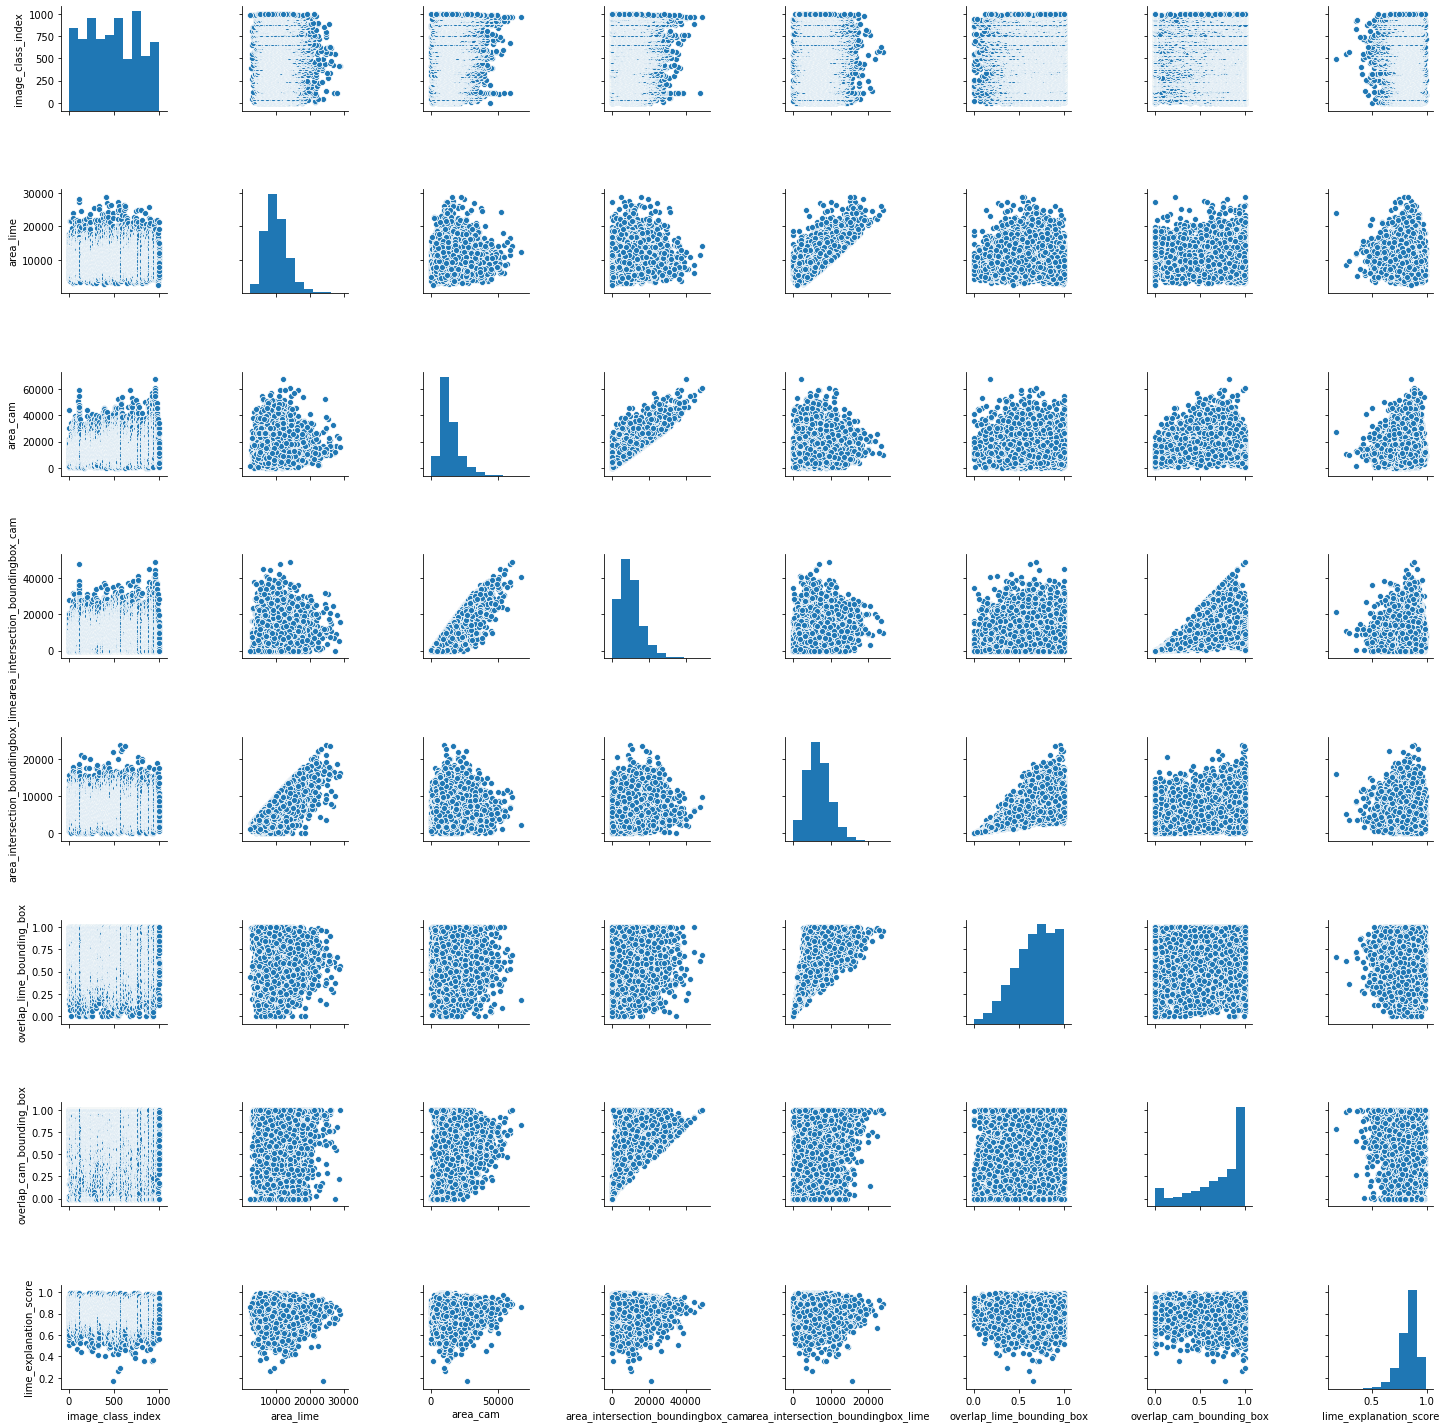

In [85]:
import seaborn as sns
sns.pairplot(all_results_df)

In [31]:
def loadBoundingBoxes(pathToXML, imageSizeX, imageSizeY):
    returnValues = []
    root = ET.parse(pathToXML).getroot()
    xmlImageX = root.findall('size/width')
    xmlImageY = root.findall('size/height')
    if len(xmlImageY) != 1:
        print("ERROR: more than 1 image heigth found")
    if len(xmlImageX) != 1:
        print("ERROR: more than 1 image width found")
    xmlImageX = int(xmlImageX[0].text)
    xmlImageY = int(xmlImageY[0].text)
    
    #print("xmlPictureSize: X: {}, Y: {}".format(xmlImageX, xmlImageY))
    
    xScallingFactor = imageSizeX*1.0 / xmlImageX
    yScallingFactor = imageSizeY*1.0 / xmlImageY
    #print("scalling factors x={} y={}".format(xScallingFactor, yScallingFactor))
    
    for bndbox in root.findall('object/bndbox'):
        boundingBox = {}
        for child in bndbox:
            boundingBox[child.tag] = int(child.text)
        boundingBox['xminScalled'] = int(boundingBox['xmin']*xScallingFactor)
        boundingBox['yminScalled'] = int(boundingBox['ymin']*yScallingFactor)
        boundingBox['xmaxScalled'] = int(boundingBox['xmax']*xScallingFactor)
        boundingBox['ymaxScalled'] = int(boundingBox['ymax']*yScallingFactor)
        boundingBox['xdiff'] = boundingBox['xmax'] - boundingBox['xmin']
        boundingBox['ydiff'] = boundingBox['ymax'] - boundingBox['ymin']
        boundingBox['xdiffScalled'] = boundingBox['xmaxScalled'] - boundingBox['xminScalled']
        boundingBox['ydiffScalled'] = boundingBox['ymaxScalled'] - boundingBox['yminScalled']
        returnValues.append(boundingBox)
    print(returnValues)
    return(returnValues)